<h1 align="center">Apprentissage Statistique - TP4</h1>
<h1 align="center">The skin dataset</h1>
- **Isnardy Antoine**
- **Ouillade Sophie**

----
Le dataset que nous avons utilisé est disponible à l'adresse suivante : https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation#. Il présente des exemples labellisés "skin", et d'autres exemples labelisés "non-skin". Il conveindra donc tout au long de l'étude d'essayer de discriminer le caractère skin ou pas, qui constitue la variable de décision $y$.

Les exemples labellisés "skin" ont été obtenus en échantillonant de manière aléatoire les valeurs de pixels au format RGB d'images de visages. Ces visages proviennent de deux bases de données: FERET et PAL. Les individus y sont discriminés comme suit:
- L'âge : jeune, âge moyen, vieux
- Le groupe ethnique : blanc, noir, asiatique
- Le genre : féminin, masculin

In [1]:
# Packages nécessaires

import pandas as pd
import numpy as np

from bokeh.charts import Bar
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.palettes import RdYlBu3
output_notebook()

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

np.random.seed(42)

Loading BokehJS ...

# Data loading

In [2]:
raw = pd.read_csv('./data/Skin_NonSkin.txt', sep='\t', header=None, names=['B', 'G', 'R', 'y'])

In [3]:
X = raw[['B', 'G', 'R']]
y = raw['y'].values
y[y==2] = 0

In [4]:
X.head()

,B,G,R
0,74,85,123
1,73,84,122
2,72,83,121
3,70,81,119
4,70,81,119


In [5]:
print("Nb d'observations :      {}".format(X.shape[0]))
print("Nb de classes :          {}".format(len(np.unique(y))))
print("Nb d'individus skin:     {}").format((len(y[y==1])))
print("Nb d'individus non-skin: {}").format((len(y[y==0])))
print("% d'individus skin:      {}").format(round(len(y[y==1])*1./len(y)*100, 1))
print("% d'individus non-skin:  {}").format(round(len(y[y==0])*1./len(y)*100, 1))

Nb d'observations :      245057
Nb de classes :          2
Nb d'individus skin:     50859
Nb d'individus non-skin: 194198
% d'individus skin:      20.8
% d'individus non-skin:  79.2


- Le dataset semble déséquilibré, puisque les deux classes ne sont pas présentes dans des proportions équivalentes. Ce point devra faire l'objet d'une attention particulière par la suite.

- En réalité, ceci est simplement pris en compte dans la plupart des algorithmes en ajustant la pénalisation des fonctions de perte de manière inversement proportionnelle à la fréquence de la classe. Par exemple, considérons le problème de minimisation initial des SVM:
$$\min_w \frac{1}{2} \|w\|^2 + C\sum_i \xi_i$$
Prendre en compte le caractère non balancé du dataset consiste en l'introduction d'un $C_{skin}$ et un $C_{non-skin}$, calculé comme suit: $C_i = C\times\frac{n_{samples}}{(n_{classes} * np.bincount(y))}$.

In [6]:
X.describe()

,B,G,R
count,245057.000000,245057.000000,245057.000000
mean,125.065446,132.507327,123.177151
std,62.255653,59.941197,72.562165
min,0.000000,0.000000,0.000000
25%,68.000000,87.000000,70.000000
50%,139.000000,153.000000,128.000000
75%,176.000000,177.000000,164.000000
max,255.000000,255.000000,255.000000


# Data visualization
Le problème comporte 3 dimensions. Afin de mieux visualiser les données, rélisons une PCA; cela semble peu risqué puisqu'il s'agit de passer de 3 à 2 dimensions.

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [9]:
X_PCA = pca.transform(X)

In [10]:
print('Pourcentage de variance expliqué par les deux premiers axes: %.3f'%pca.explained_variance_ratio_.sum())

Pourcentage de variance expliqué par les deux premiers axes: 0.965


- La PCA ne semble pas avoir entraîné une perte importante d'information.

In [11]:
def plot_classif(X_, y_, title, legend=['skin', 'non-skin'], palette=RdYlBu3):
    fig = figure(title=title)
    
    X_1 = X_[y_==1]
    idx_1 = np.random.randint(len(X_1), size=len(X_1)/20)
    X_1 = X_1[idx_1]
    X_minus_1 = X_[y==0]
    idx_minus_1 = np.random.randint(len(X_minus_1), size=len(X_minus_1)/20)
    X_minus_1 = X_minus_1[idx_minus_1]
    
    fig.circle(X_1[:,0], X_1[:,1], color=palette[0], legend=legend[0])
    fig.circle(X_minus_1[:,0], X_minus_1[:,1], color=palette[2], legend=legend[1])
    return fig

In [12]:
plot_pca = plot_classif(X_PCA, y, 'PCA of X')
show(plot_pca)

- Pour plus de visibilité, la PCA est visualisée pour un nombre réduit de points (après un sampling stratifié). Le même type de résultat avait été obtenu pour l'ensemble des données, mais produisait un graphe de taille 18Mo, ce qui explique la réduction du nombre de points.
- Au vu des résultats, les exemples skin semblent clairement groupés, bien que mélangés à des exemples non-skin.
- Nous pouvons donc être plutôt confiants sur la capacité d'un classifieur à traiter au moins correctement les exemples skin: par exemple pour un SVM avec un kernel gaussien, nous pouvons nous attendre à une frontière de décision englobant tous les exemples skin. Les erreurs devraient donc plutôt se retrouver sur des non-skin prévus comme skin.
---
- Au vu des résultats de la réduction de dimension en 2D (et de la discrimination correcte des deux classes), nous décidons de garder cette représentation afin de pouvoir représenter nos résultat sur des graphes, et surtout les frontières par la suite.

In [13]:
X = X_PCA

# Preprocessing

Cette étape consiste en le centrage et la réduction des données; il s'agit d'un prérequis pour certaine méthodes comme les SVM, mais aussi des régressions pénalisées. Cette étape n'a de toutes manières pas grande incidence ici, puisque les 3 variables sont sur la même échelle.

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
X = StandardScaler().fit_transform(X)

# Classification
Cette section comporte des test effectuées sur plusieurs méthodes destinées à discriminer skin VS. non-skin.

### Définition des données train - test

A présent, nous adressons 2 aspects du problème :
- Mettre de côté un dataset de test qui ne sera jamais utilisé pour l'entraînement, mais qui servira à évaluer la performance du classifieur
- Sampling: en effet, si nous considérions un découpage classique 80% train - 20% test, l'échantillon d'entrainement serait constitué de 200k exemples. Or, même en considérant les découpages effectués lors de la cross-validation, la taille de l'échantillon d'entraînement final resterait trop élevée pour une seule machine, puisque certaines méthodes comme SVM requièrent le stockage de la matrice de Gram, de taille $\mathcal{O}($n_sample$^2$) (Note: des méthodes d'optimisation comme Coordinate Descent existent pour ne pas à avoir à stocker la matrice de Gram, mais elles ne sont pas utilisées ici); il nous faut donc considérer un échantillon de la base totale pour garder un nombre raisonnable d'observations.
- Au vu de la densité des points appartenant aux deux classes (chaque classe est clairement identifiable dans l'espace, comme représenté ci-dessus), cette hypothèse reste raisonnable.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.2, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=.8, stratify=y_train)

In [18]:
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

In [19]:
print("Nb d'échantillons d'apprentissage :  {}".format(X_train.shape[0]))
print("Nb d'échantillons de validation :    {}".format(X_test.shape[0]))

Nb d'échantillons d'apprentissage :  39208
Nb d'échantillons de validation :    9803


### Pipeline

A présent, définissons un framework général. Il nous permettra successivement de:
- Sélectionner les meilleurs paramètres par cross-validation
- Evaluer l'erreur sur l'ensemble de test
- Représenter les résultats obtenus:
    - Graphe de frontière de décision obtenu
    - Score sur l'ensemble de test
    - Matrice de confusion sur ce même ensemble, à lire comme suit:
        
        
||Prédiction 0   |Prédiction 1  |
|-|---------------|--------------|
|**Vrais 0**|Vrais négatifs |Faux positifs |
|**Vrais 1**|Faux négatifs  |Vrais positifs|

In [20]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix

def pipeline(estimator, param_grid, X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test):
    clf = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, verbose=1)
    clf.fit(X_tr, y_tr)
    print clf.best_estimator_
    print clf.score(X_te, y_te)

In [21]:
def display_results(title, clf, score, y_preds):
    print('-----')
    print(title)
    print('-----')
    h = .2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(111)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()
    
    print('')
    print('Test sur les données test: %.4f' % score)
    print('')
    print('Matrice de confusion:')
    print confusion_matrix(y_test, y_preds)

### Méthodes de classification

In [22]:
methods = []
scores = []

#### SVM

In [23]:
from sklearn.svm import SVC

In [24]:
Cs = [.001, .01, .1, 1]
kernels = ['linear', 'poly', 'rbf']
param_grid = dict(C=Cs, kernel=kernels)

In [25]:
svc = SVC(class_weight='balanced')

In [26]:
pipeline(svc, param_grid)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.3min finished


SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.977557890442


In [27]:
clf = SVC(class_weight='balanced', C=1, kernel='rbf')
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_preds = clf.predict(X_test)

-----
SVM
-----


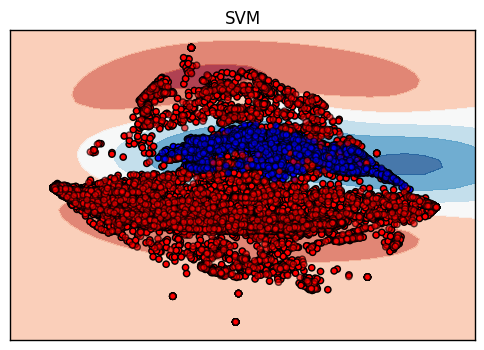


Test sur les données test: 0.9776

Matrice de confusion:
[[7548  220]
 [   0 2035]]


In [28]:
display_results('SVM', clf, score, y_preds)

- Les résultats semblent conformes à ce que nous pouvions attendre: le noyau préféré est un noyau gaussien.
- La frontière de décision englobe les données labellisées skin.
- Comme indiqué plus haut, les erreurs se portent effectivement sur les non-skin taggés skin

In [29]:
methods.append('SVM')
scores.append(score)

#### Arbre de décision

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
max_depths = [2, 5, 10]
param_grid = dict(max_depth=max_depths)

In [32]:
dtree = DecisionTreeClassifier(class_weight='balanced')

In [33]:
pipeline(dtree, param_grid)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.985820667143


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.3s finished


In [34]:
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=10)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_preds = clf.predict(X_test)

-----
Decision Tree
-----


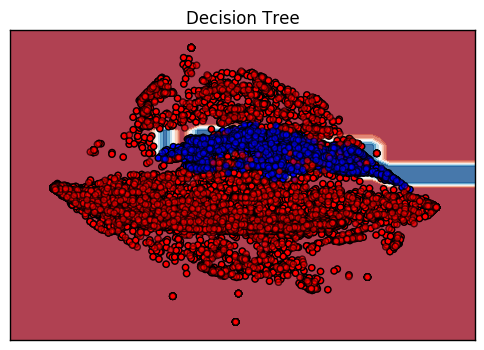


Test sur les données test: 0.9858

Matrice de confusion:
[[7637  131]
 [   8 2027]]


In [35]:
display_results('Decision Tree', clf, score, y_preds)

- La cross-validation indique qu'une profondeur de 10 est optimale. Ceci paraît assez élevé pour un jeu de données à 2 features. Cependant, et comme les données labellisées sont particulièrement regroupées, cela fait sens. Une profondeur élevée cherche à épouser au maximum la forme des données skin, ce qui est légitime étant donnée qu'elles sont peu dispersées.
- Si le score de classification est globalement plus élevé que pour SVM, nous remarquons cependant que cette fois-ci, des exemples skin ont été labellisés non-skin, ce qui n'était pas le cas auparavant.

In [36]:
methods.append('Decision Tree')
scores.append(score)

#### Bagging (Random Forest)

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
n_estimators = [10, 50, 100]
max_depths = [2, 5, 10]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depths)

In [39]:
rf = RandomForestClassifier(class_weight='balanced')

In [40]:
pipeline(rf, param_grid)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   12.5s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.985310619198


In [41]:
np.random.seed(42)
clf = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_preds = clf.predict(X_test)

-----
Random Forest
-----


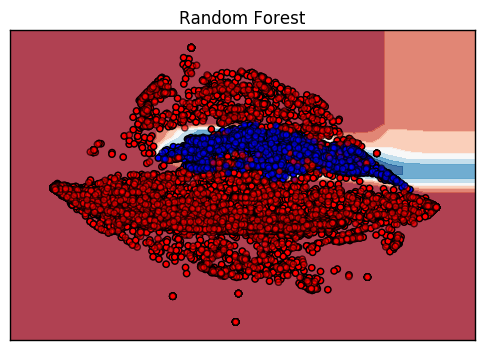


Test sur les données test: 0.9860

Matrice de confusion:
[[7639  129]
 [   8 2027]]


In [42]:
display_results('Random Forest', clf, score, y_preds)

- Comme nous pouvions nous y attendre, les résultats obtenus avec une forêt aléatoire (en moyennant sur un grand nombre de modèles) sont légèrement meilleurs qu'avec un seul arbre, puisque la performance sur les données de test a augmenté.
- Par ailleurs, nous remarquons que quelques exemples skin ont encore été mal classés, mais il y a moins de données mal classées dans l'ensemble. Ce nombre varie légèrement avec l'aléa (seed). 

In [43]:
methods.append('Random Forest')
scores.append(score)

#### Boosting (Adaboost)

In [44]:
from sklearn.ensemble import AdaBoostClassifier

In [45]:
n_estimators = [10, 50, 100, 200]
param_grid = dict(n_estimators=n_estimators)

In [46]:
base_clf = DecisionTreeClassifier(class_weight='balanced')
ab = AdaBoostClassifier(base_clf)

In [47]:
pipeline(ab, param_grid)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.0s finished


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=None)
0.989288993165


In [48]:
clf = AdaBoostClassifier(base_clf, n_estimators=100)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_preds = clf.predict(X_test)

-----
ADA Boost
-----


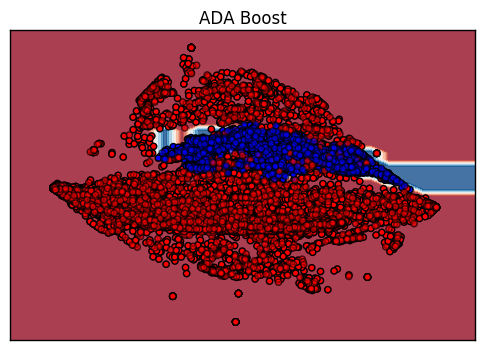


Test sur les données test: 0.9898

Matrice de confusion:
[[7718   50]
 [  50 1985]]


In [49]:
display_results('ADA Boost', clf, score, y_preds)

- Le boosting nous aide de nouveau à améliorer globalement les résultats de classficiation.
- Cependant, plus d'exemples skin sont taggués non-skin cette fois-ci, contrairement à ce que nous avions obtenu avec Random Forest. Parmi les observations mal classées, le nombre de faux positifs comparé au nombre de faux négatif est ici du même ordre de grandeur (50 pour les deux) alors que précédement, il y avait beaucoup plus de faux positifs que de faux négatifs.

In [50]:
methods.append('AdaBoost')
scores.append(score)

#### Réseaux de neurones

In [51]:
from sklearn.neural_network import MLPClassifier
np.random.seed(42)

In [52]:
hidden_layer_sizes = [(5,), (10,), (50,), (100,), (200,)]
param_grid = dict(hidden_layer_sizes=hidden_layer_sizes)

In [53]:
neural = MLPClassifier(activation='logistic')

In [54]:
#pipeline(neural, param_grid)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   33.3s finished

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

0.979904110986

In [55]:
clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(50,))
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_preds = clf.predict(X_test)

-----
Neural
-----


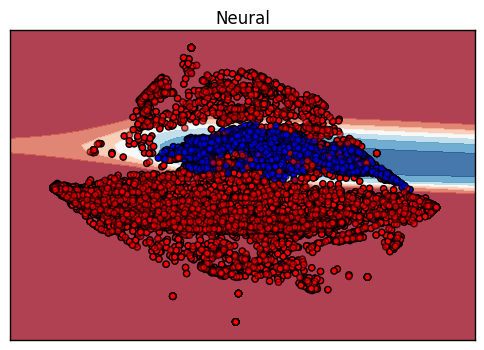


Test sur les données test: 0.9799

Matrice de confusion:
[[7577  191]
 [   6 2029]]


In [56]:
display_results('Neural', clf, score, y_preds)

- L'optimisation suggère de prendre un réseau comportant 50 neurones dans la couche cachée.
- Le nombre de faux positif est encore bien supérieur au nombre de faux négatif.

In [57]:
methods.append('Neural')
scores.append(score)

#### K-NN

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
n_neighbors = [2, 5, 10, 50]
param_grid = dict(n_neighbors=n_neighbors)

In [60]:
knn = KNeighborsClassifier()

In [61]:
pipeline(knn, param_grid)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.989901050699


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.1s finished


In [62]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_preds = clf.predict(X_test)

-----
KNN
-----


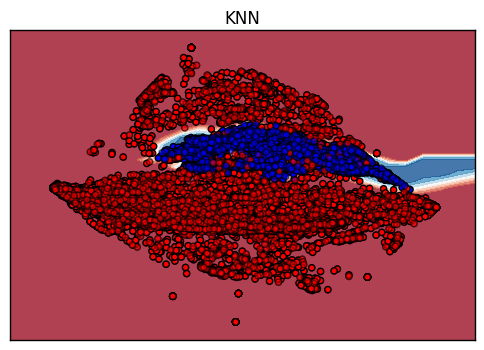


Test sur les données test: 0.9899

Matrice de confusion:
[[7699   69]
 [  30 2005]]


In [63]:
display_results('KNN', clf, score, y_preds)

- L'optimisation suggère de prendre comme paramètre du modèle un nombre de voisin égal à 5.
- Cette méthode donne un bon score, du même ordre de grandeur que Adaboost.
- Le bon résultat de cette méthode n'est ici pas surprenant : les données d'une même classe sont majoritairement regroupées ensemble. Les plus proches voisins d'un point sont donc fortement semblables à celui-ci.
- Il y a toujours plus de non-skin mal classés que de skin mal classés, mais le ratio est plus faible que pour les autres méthodes.

In [64]:
methods.append('KNN')
scores.append(score)

# Conclusion

Résumé des résultats sur données test

In [65]:
from bokeh.models import Range1d
from bokeh.charts.attributes import CatAttr
df = pd.DataFrame({'method': methods, 'score': np.array(scores)})
df = df.sort_values(by='score')

In [67]:
bar = Bar(df, values='score', title="Résumé des résultats sur données test",
          legend=None, color='darkblue',
          label=CatAttr(columns=['method'], sort=False))
bar.set(y_range=Range1d(.97, 1))
show(bar)

En conclusion, nous pouvons voir que toutes les méthodes essayées donnent en général de bons résultat : moins de 3% d'erreurs. Ces bons résultats peuvent être attribués au fait que les données initiales représentées dans les deux premiers axes de l'analyse en composantes principales sont quasiment séparables. En effet, "à la main" il est facile de déterminer une frontière englobant tous les échantillons labellisés comme "skin".

Cette structure des données est aussi responsable du fait que en général il y a plus de faux positifs que de faux négatifs. En effet, certains échantillons *non-skin* sont représentés proches de l'ensemble des échantillons *skin* mais l'inverse est très peu probable : il n'y a presque pas d'échantillon *skin* dans l'ensemble des *non-skin*. 

Le choix de la méthode finale à appliquer se fera **en fonction de l'utilisation que l'on souhaite en faire**:
- Si nous voulons simplement obtenir l'erreur globale la plus faible nous choisirons plutôt les méthodes Adaboost ou KNN qui atteingnent presque 99% de bonnes réponses.
- Si le but est de ne pas laisser un *skin* de coté, quitte à labelisé des échantillons *skin* alors qu'ils ne le sont pas (minimisation du nombre de faux négatifs), nous choisirons plutôt la méthode des SVM qui arrive à n'avoir aucun faux-négatif.
- A l'inverse, si le but est de se tromper le moins possible en prédisant un *skin* (minimisation du nombre de faux-positifs), nous choisirons plutot la méthode Adaboost.